In [1]:
import os
import sys

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from itertools import product

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import xarray as xr

In [5]:
from glob import glob

In [6]:
def demean(x): 
    return x - x.loc['1981':'2010',].mean()

In [7]:
# def make_categories(x): 
#     def qcut(x): 
#         clim = x.loc['1981':'2010',:]
# #         quantiles = [clim.quantile(q=q) for q in [0.2,0.4,0.6,0.8]]
#         quantiles = [clim.quantile(q=q) for q in [0.33333,0.66666]]
#         quantiles.insert(0, -np.inf)
#         quantiles.append(np.inf)
#         return pd.cut(x.values.flatten(), quantiles, labels=[-1,0,1]).to_dense().flatten()
#     quantiles_seasons = x.groupby([x.index.month]).apply(qcut)
#     dummy = x.values.flatten() * np.nan
#     for month in range(1,13): 
#         dummy[np.where(x.index.month == month)] = quantiles_seasons[month]
#     return dummy

In [8]:
def get_clim_quantiles(x, kind='terciles'): 
    clim = x.loc['1981':'2010',]
    def get_quantiles(clim):
        if kind == 'terciles': 
            quantiles = [clim.quantile(q=q) for q in [0.33333,0.66666]]
            return pd.Series(np.array(quantiles), index = ['T1','T2'])
        elif kind == 'quintiles':
            quantiles = [clim.quantile(q=q) for q in [0.2, 0.4, 0.6, 0.8]]
            return pd.Series(np.array(quantiles), index = ['Q1','Q2','Q3','Q4'])
    return clim.groupby(clim.index.month).apply(get_quantiles)

In [9]:
def make_categories(x, kind='terciles'): 
    def qcut(x, kind='terciles'): 
        clim = x.loc['1981':'2010',:]
        if kind == 'terciles': 
            quantiles = [clim.quantile(q=q) for q in [0.33333,0.66666]]
            quantiles.insert(0, -np.inf)
            quantiles.append(np.inf)
            return pd.cut(x.values.flatten(), quantiles, labels=[-1,0,1]).to_dense().flatten()
        elif kind == 'quintiles':
            quantiles = [clim.quantile(q=q) for q in [0.2,0.4,0.6,0.8]]
            quantiles.insert(0, -np.inf)
            quantiles.append(np.inf)
            return pd.cut(x.values.flatten(), quantiles, labels=[-2, -1, 0 , 1, 2]).to_dense().flatten()        
    quantiles_seasons = x.groupby([x.index.month]).apply(qcut, **{'kind':kind})
    dummy = x.values.flatten() * np.nan
    for month in range(1,13): 
        dummy[np.where(x.index.month == month)] = quantiles_seasons[month]
    return dummy

In [10]:
dpath = '/home/nicolasf/operational/VCSN/outputs/'

In [11]:
variable = 'TMean'

In [12]:
lfiles = glob(os.path.join(dpath, variable, 'VCSN_monthly_{}_????_nogrid.nc'.format(variable)))

In [13]:
lfiles.sort()

In [14]:
lfiles

['/home/nicolasf/operational/VCSN/outputs/TMean/VCSN_monthly_TMean_1972_nogrid.nc',
 '/home/nicolasf/operational/VCSN/outputs/TMean/VCSN_monthly_TMean_1973_nogrid.nc',
 '/home/nicolasf/operational/VCSN/outputs/TMean/VCSN_monthly_TMean_1974_nogrid.nc',
 '/home/nicolasf/operational/VCSN/outputs/TMean/VCSN_monthly_TMean_1975_nogrid.nc',
 '/home/nicolasf/operational/VCSN/outputs/TMean/VCSN_monthly_TMean_1976_nogrid.nc',
 '/home/nicolasf/operational/VCSN/outputs/TMean/VCSN_monthly_TMean_1977_nogrid.nc',
 '/home/nicolasf/operational/VCSN/outputs/TMean/VCSN_monthly_TMean_1978_nogrid.nc',
 '/home/nicolasf/operational/VCSN/outputs/TMean/VCSN_monthly_TMean_1979_nogrid.nc',
 '/home/nicolasf/operational/VCSN/outputs/TMean/VCSN_monthly_TMean_1980_nogrid.nc',
 '/home/nicolasf/operational/VCSN/outputs/TMean/VCSN_monthly_TMean_1981_nogrid.nc',
 '/home/nicolasf/operational/VCSN/outputs/TMean/VCSN_monthly_TMean_1982_nogrid.nc',
 '/home/nicolasf/operational/VCSN/outputs/TMean/VCSN_monthly_TMean_1983_nogr

In [15]:
dset = xr.open_mfdataset(lfiles)

In [16]:
dset

<xarray.Dataset>
Dimensions:     (agent: 11491, time: 552)
Coordinates:
  * agent       (agent) int64 3027 3106 3380 4782 ... 31177 31178 31179 31180
  * time        (time) datetime64[ns] 1972-01-31 1972-02-29 ... 2017-12-31
Data variables:
    latitudes   (time, agent) float64 dask.array<shape=(552, 11491), chunksize=(12, 11491)>
    longitudes  (time, agent) float64 dask.array<shape=(552, 11491), chunksize=(12, 11491)>
    TMean       (time, agent) float64 dask.array<shape=(552, 11491), chunksize=(12, 11491)>

In [17]:
regions = pd.read_csv('../../data/VCSN/VCSN_join_regions.csv')

In [18]:
dict_region_ID = dict(zip(range(1,7),['NNI','WNI','ENI','NSI','WSI','ESI']))

In [19]:
dict_region_ID

{1: 'NNI', 2: 'WNI', 3: 'ENI', 4: 'NSI', 5: 'WSI', 6: 'ESI'}

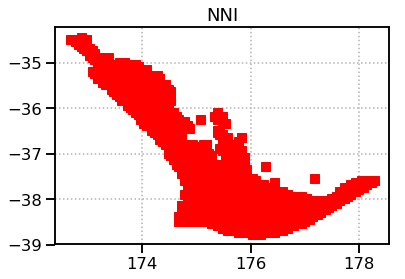

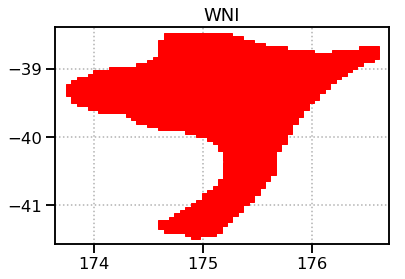

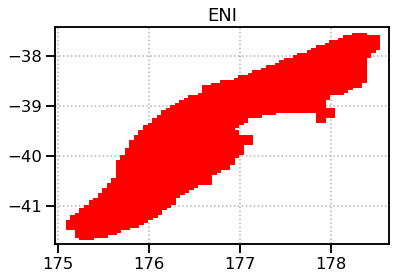

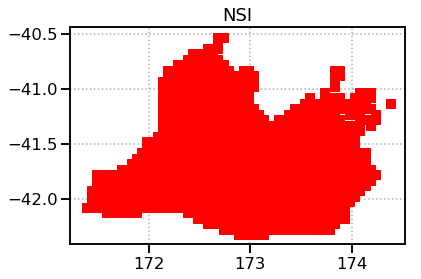

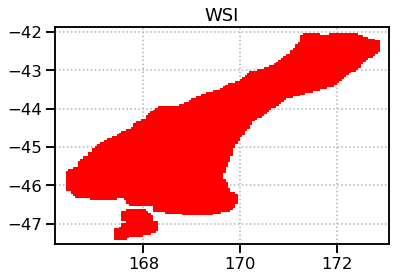

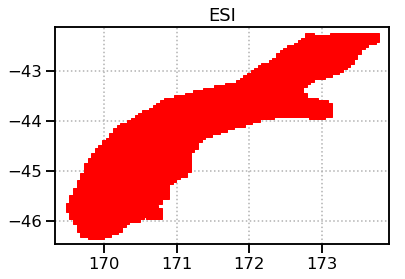

In [20]:
for region_ID in [1,2,3,4,5,6]: 
    region = regions.query('Region_ID == {}'.format(region_ID))
    region_nc = dset.sel(agent=region['AGENT_NO'].values)
    lons = region_nc.longitudes[0,:].data
    lats = region_nc.latitudes[0,:].data
    vals = region_nc[variable][0,:].data
    latlons = region_nc.sel(time='1972-01-31').to_dataframe().sort_index()[['longitudes','latitudes']] 
    region_nc_agents = region_nc.to_dataframe()[variable].unstack().T 
    if variable == 'Rain': 
        region_nc_agents_r3 =  region_nc_agents.rolling(window=3, min_periods=3).sum()
    else: 
        region_nc_agents_r3 =  region_nc_agents.rolling(window=3, min_periods=3).mean()
    region_nc_agents_r3.dropna(inplace=True) 
    ave_region_nc_agents_r3 = region_nc_agents_r3.mean(axis=1) 
    ave_region_nc_agents_r3 = ave_region_nc_agents_r3.to_frame() 
    ave_region_nc_agents_r3.columns = ['R3']
    ave_region_nc_agents_r3.loc[:,'cat3'] = make_categories(ave_region_nc_agents_r3, kind='terciles')
    ave_region_nc_agents_r3.loc[:,'cat5'] = make_categories(ave_region_nc_agents_r3.loc[:,['R3']], kind='quintiles')
    ave_region_nc_agents_r3.loc[:,'anomalies'] = \
    ave_region_nc_agents_r3[['R3']].groupby(ave_region_nc_agents_r3.index.month).apply(demean)
    ave_region_nc_agents_r3.loc[:,'region'] = dict_region_ID[region_ID]
    ave_region_nc_agents_r3.to_csv('../../outputs/VCSN/{}_{}_regional_ave_time_series.csv'.format(variable, dict_region_ID[region_ID]))
        
    ### climatological quantiles
    clim = ave_region_nc_agents_r3.loc['1981':'2010','R3']
    clim_stats = clim.groupby(clim.index.month).describe(percentiles=[0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.33, 0.66])
    clim_stats.columns.name = variable
    clim_stats.to_csv('../../outputs/VCSN/quantiles_clim_{}_{}.csv'.format(variable, dict_region_ID[region_ID]))
    
    f, ax = plt.subplots()
    ax.plot(latlons.longitudes, latlons.latitudes, 'rs')
    ax.set_title(dict_region_ID[region_ID])
    ax.grid(ls=':')
    f.savefig('../../figures/VCSN/region_agents_{}.png'.format(dict_region_ID[region_ID]), dpi=200)

In [21]:
ave_region_nc_agents_r3.head()

,R3,cat3,cat5,anomalies,region
time,,,,,
1972-03-31,13.617023,-1.0,-2.0,-0.789410,ESI
1972-04-30,12.637581,0.0,0.0,-0.080909,ESI
1972-05-31,10.188330,0.0,0.0,-0.002035,ESI
1972-06-30,6.546628,-1.0,-2.0,-0.853778,ESI
1972-07-31,4.204802,-1.0,-2.0,-1.092198,ESI
